<a href="https://colab.research.google.com/github/Kathyllen/Compesa/blob/Subst_HD/C%C3%B3pia_IA_Subst_HD_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Importações

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy  as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from keras import callbacks
import lightgbm as lgb
from keras.models import Sequential
from keras.layers import Dense, Dropout
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.model_selection import learning_curve
import warnings
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
def ignore_warn(*args, **kwargs):
    pass
warnings.warn = ignore_warn
from scipy import stats
import datetime as dt
import pickle
from datetime import date
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix , accuracy_score
pd.set_option('display.max_columns', None)

In [3]:
path_predict = r'/content/20230414_GNR_Centrall.csv'
path_train = r'/content/20230410_train.csv'

predict_df = pd.read_csv(path_predict)
train_df = pd.read_csv(path_train, encoding='ISO-8859-1')

In [4]:
predict_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23354 entries, 0 to 23353
Data columns (total 46 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   IMOV_ID                       23354 non-null  int64  
 1   LOCA_ID                       23354 non-null  int64  
 2   STCM_CDSETORCOMERCIAL         23354 non-null  int64  
 3   IPER_ID                       23354 non-null  int64  
 4   IMOV_IDSUBCATEGORIAPRINCIPAL  23354 non-null  int64  
 5   IDADE                         23354 non-null  int64  
 6   DATA_INSTALACAO_HD            23354 non-null  object 
 7   IMOV_NNMORADOR                20936 non-null  float64
 8   QTDECONOMIARESIDENCIAL        23354 non-null  int64  
 9   QTDECONOMIACOMERCIAL          23354 non-null  int64  
 10  QTDECONOMIAINDUSTRIAL         23354 non-null  int64  
 11  QTDECONOMIAPUBLICO            23354 non-null  int64  
 12  QTDANORMALIDADEANTTOTAL       23354 non-null  int64  
 13  Q

In [5]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 116586 entries, 0 to 116585
Data columns (total 65 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   IMOV_ID                       116586 non-null  int64  
 1   LOCA_ID                       116586 non-null  int64  
 2   STCM_CDSETORCOMERCIAL         116586 non-null  int64  
 3   IPER_ID                       116586 non-null  int64  
 4   IMOV_IDSUBCATEGORIAPRINCIPAL  116586 non-null  int64  
 5   IDADE                         116586 non-null  int64  
 6   DATA_INSTALACAO_HD            116586 non-null  object 
 7   DATA_INSTALACAO_HD_NOVO       116586 non-null  object 
 8   IMOV_NNMORADOR                111996 non-null  float64
 9   QTDECONOMIARESIDENCIAL        116586 non-null  int64  
 10  QTDECONOMIACOMERCIAL          116586 non-null  int64  
 11  QTDECONOMIAINDUSTRIAL         116586 non-null  int64  
 12  QTDECONOMIAPUBLICO            116586 non-nul

### Inspeção das localidades presentes nas bases

In [6]:
print('Localidades presentes na base de treino:')
print('\n')
print(train_df['LOCA_ID'].unique())
print('_ _'*30)
print('\n')
print('Localidades presentes na base de predição:')
print('\n')
print(predict_df['LOCA_ID'].unique())
print('_ _'*30)
print('\n')
print('Localidades presentes em ambas as bases:')
print('\n')
train_df.loc[train_df['LOCA_ID'].isin(predict_df['LOCA_ID'])]['LOCA_ID'].unique()

Localidades presentes na base de treino:


[  7 360  11  12 347  13  16  17  19  23 339  29  30 752  32  40  41  45
  46 438  51 340 309  53  60  64  75  76  79 342 735  84 193  88 203 274
  93 177  96  99 105 180 107 734 109 728 111 171 226 741 341 114 118 122
 125 126 129 131 132 137 141 145 153 154 164 165  14  20  25  31  35 319
  39 338 178  57 789  72 179 219 344  94 323 120 294 139 148 261 763   1
   3  10  15  21 186  54  62  69 181 199 172 160  18 785 766 175  55  66
 733 169 324 136 198 224 200 240  28  38  49  61 724 732 232 170 112 113
 124 134 146 158 451  86 218 788 106 108 115 157   8 743  68 703  89 104
 123 130 147 167 152 159 237  77  82  85  98 133 155 156 769 162 230  26
 176  36  58  91 767   2  33  50 746 183 173  78  90  47  73  87 239 102
 246 190  56 764 765  95 207  52 727 197  44 225 317 628 756 214 272 119
 434 507 140 161 691 293 271 151 163   6 307  43 117 182 771 188 750 351
 787 779  67 142   5 390 144 719 223 127 332 247 101 221 174 325 348 706
  81 217

array([ 41, 131, 154, 117, 322, 337])

### Remoção de overlap entre base de treino e predição

In [7]:
print(str(len(train_df.loc[train_df['IMOV_ID'].isin(predict_df['IMOV_ID'])])) + ' Matrículas excluídas da base de treino')

train_df = train_df.loc[~train_df['IMOV_ID'].isin(predict_df['IMOV_ID'])]

977 Matrículas excluídas da base de treino


In [8]:
len(train_df.loc[~train_df['IMOV_ID'].isin(predict_df['IMOV_ID'])])

115609

In [9]:
train_df.columns

Index(['IMOV_ID', 'LOCA_ID', 'STCM_CDSETORCOMERCIAL', 'IPER_ID',
       'IMOV_IDSUBCATEGORIAPRINCIPAL', 'IDADE', 'DATA_INSTALACAO_HD',
       'DATA_INSTALACAO_HD_NOVO', 'IMOV_NNMORADOR', 'QTDECONOMIARESIDENCIAL',
       'QTDECONOMIACOMERCIAL', 'QTDECONOMIAINDUSTRIAL', 'QTDECONOMIAPUBLICO',
       'QTDANORMALIDADEPOS', 'QTDANORMALIDADEANTTOTAL',
       'QTDANORMALIDADELEITURA_ANT', 'QUANTIDADECONTAS', 'QUANTIDADERAS',
       'QTD_ANORM_HD_QUEBRADO', 'QTD_ANORM_HD_RETIRADO',
       'QTD_ANORM_HD_EMBAÇADO', 'QTD_ANORM_HD_INVERTIDO',
       'QTD_ANORM_HD_SOTERRADO', 'POCO_ID', 'N_CORTES', 'TIPO_HD',
       'CAPACIDADE_HD', 'CONS_MED_ANT_M1', 'CONS_MED_ANT_M2',
       'CONS_MED_ANT_M3', 'CONS_MED_ANT_M4', 'CONS_MED_ANT_M5',
       'CONS_MED_ANT_M6', 'CONS_MED_ANT_M7', 'CONS_MED_ANT_M8',
       'CONS_MED_ANT_M9', 'CONS_MED_ANT_M10', 'CONS_MED_ANT_M11',
       'CONS_MED_ANT_M12', 'CONS_MED_ANT_M13', 'CONS_MED_ANT_M14',
       'CONS_MED_ANT_M15', 'CONS_MED_ANT_M16', 'CONS_MED_ANT_M17',
       

In [10]:
train_df.iloc[:, 0:63] = train_df.iloc[:, 0:63].fillna(value = 0)

In [11]:
train_df['QTDECONOMIA'] = train_df['QTDECONOMIAINDUSTRIAL'] + train_df['QTDECONOMIAPUBLICO'] + train_df['QTDECONOMIACOMERCIAL'] + train_df['QTDECONOMIARESIDENCIAL']

train_df = train_df.drop(columns=['QTDECONOMIAINDUSTRIAL', 'QTDECONOMIAPUBLICO', 'QTDECONOMIACOMERCIAL', 'QTDECONOMIARESIDENCIAL'])

In [12]:
predict_df['QTDECONOMIA'] = predict_df['QTDECONOMIAINDUSTRIAL'] + predict_df['QTDECONOMIAPUBLICO'] + predict_df['QTDECONOMIACOMERCIAL'] + predict_df['QTDECONOMIARESIDENCIAL']

predict_df = predict_df.drop(columns=['QTDECONOMIAINDUSTRIAL', 'QTDECONOMIAPUBLICO', 'QTDECONOMIACOMERCIAL', 'QTDECONOMIARESIDENCIAL'])

In [13]:
'''train_df.iloc[:, 23:47] = train_df.iloc[:, 23:47].astype('int64')

train_df.iloc[:, 47:59] = train_df.iloc[:, 47:59].astype('int64')'''

"train_df.iloc[:, 23:47] = train_df.iloc[:, 23:47].astype('int64')\n\ntrain_df.iloc[:, 47:59] = train_df.iloc[:, 47:59].astype('int64')"

In [14]:
'''train_df['TIPO_HD'] = train_df['TIPO_HD'].astype('str')
train_df['CAPACIDADE_HD'] = train_df['CAPACIDADE_HD'].astype('str')

train_df['HD'] = train_df['TIPO_HD'] + train_df['CAPACIDADE_HD']

train_df = train_df.drop(columns=['TIPO_HD', 'CAPACIDADE_HD'])'''

"train_df['TIPO_HD'] = train_df['TIPO_HD'].astype('str')\ntrain_df['CAPACIDADE_HD'] = train_df['CAPACIDADE_HD'].astype('str')\n\ntrain_df['HD'] = train_df['TIPO_HD'] + train_df['CAPACIDADE_HD']\n\ntrain_df = train_df.drop(columns=['TIPO_HD', 'CAPACIDADE_HD'])"

In [15]:
'''predict_df['TIPO_HD'] = predict_df['TIPO_HD'].astype('str')
predict_df['CAPACIDADE_HD'] = predict_df['CAPACIDADE_HD'].astype('str')

predict_df['HD'] = predict_df['TIPO_HD'] + predict_df['CAPACIDADE_HD']

predict_df = predict_df.drop(columns=['TIPO_HD', 'CAPACIDADE_HD'])'''

"predict_df['TIPO_HD'] = predict_df['TIPO_HD'].astype('str')\npredict_df['CAPACIDADE_HD'] = predict_df['CAPACIDADE_HD'].astype('str')\n\npredict_df['HD'] = predict_df['TIPO_HD'] + predict_df['CAPACIDADE_HD']\n\npredict_df = predict_df.drop(columns=['TIPO_HD', 'CAPACIDADE_HD'])"

In [16]:
'''train_df['HD'] = train_df['HD'].astype('int64')
predict_df['HD'] = predict_df['HD'].astype('int64')'''

"train_df['HD'] = train_df['HD'].astype('int64')\npredict_df['HD'] = predict_df['HD'].astype('int64')"

In [17]:
train_df = train_df.drop(columns=['TIPO_HD'])
predict_df = predict_df.drop(columns=['TIPO_HD'])

In [18]:
train_df.columns[46:58]

Index(['CONSUMO_MED_POS_M1', 'CONSUMO_MED_POS_M2', 'CONSUMO_MED_POS_M3',
       'CONSUMO_MED_POS_M4', 'CONSUMO_MED_POS_M5', 'CONSUMO_MED_POS_M6',
       'CONSUMO_MED_POS_M7', 'CONSUMO_MED_POS_M8', 'CONSUMO_MED_POS_M9',
       'CONSUMO_MED_POS_M10', 'CONSUMO_MED_POS_M11', 'CONSUMO_MED_POS_M12'],
      dtype='object')

In [19]:
train_df.columns[22:46]

Index(['CONS_MED_ANT_M1', 'CONS_MED_ANT_M2', 'CONS_MED_ANT_M3',
       'CONS_MED_ANT_M4', 'CONS_MED_ANT_M5', 'CONS_MED_ANT_M6',
       'CONS_MED_ANT_M7', 'CONS_MED_ANT_M8', 'CONS_MED_ANT_M9',
       'CONS_MED_ANT_M10', 'CONS_MED_ANT_M11', 'CONS_MED_ANT_M12',
       'CONS_MED_ANT_M13', 'CONS_MED_ANT_M14', 'CONS_MED_ANT_M15',
       'CONS_MED_ANT_M16', 'CONS_MED_ANT_M17', 'CONS_MED_ANT_M18',
       'CONS_MED_ANT_M19', 'CONS_MED_ANT_M20', 'CONS_MED_ANT_M21',
       'CONS_MED_ANT_M22', 'CONS_MED_ANT_M23', 'CONS_MED_ANT_M24'],
      dtype='object')

### Computação das estatísticas da série histórica

In [20]:
matriculas = train_df['IMOV_ID']

slope = []

slope_6 = []

intercept = []

intercept_6 = []

mean_ant = []

median_ant = []

sd_ant = []

mean_pos = []

median_pos = []

max_pos = []

matriculas_list = []

cont_zeros = []

r2 = []

x = np.arange(1, 25, 1,  dtype=int)
for matricula in matriculas:
  frame = train_df[train_df['IMOV_ID'] == matricula]
  
  y_ant = frame.iloc[0, 22:46]

  y_post = frame.iloc[0, 46:58]

  mean_ant.append(round(y_ant.mean()))

  median_ant.append(y_ant.median())

  mean_pos.append(y_post.mean())

  median_pos.append(y_post.median())

  max_pos.append(y_post.max())

  sd_ant.append(y_ant.std())

  cont_zeros.append(sum(y_ant == 0))

  res = stats.linregress(x,y_ant.astype(float))

  slope.append(res.slope)

  r2.append(res.rvalue**2)

  intercept.append(res.intercept)

  matriculas_list.append(matricula)

x = np.arange(1, 7, 1,  dtype=int)
for matricula in matriculas:
  frame = train_df[train_df['IMOV_ID'] == matricula]

  y_ant_6 = frame.iloc[0, 22:28]

  res_6 = stats.linregress(x,y_ant_6.astype(float))

  slope_6.append(res_6.slope)

  intercept_6.append(res_6.intercept)

In [21]:
df_linregress = pd.DataFrame(list(zip(matriculas_list, r2, slope, slope_6, intercept, intercept_6, mean_ant, median_ant, sd_ant, mean_pos, median_pos, max_pos, cont_zeros)),
                             columns = ['MATRICULAS', 'r2', 'SLOPE', 'SLOPE_6', 'INTERCEPT', 'INTERCEPT_6', 'MEAN_ANT', 'MEDIAN_ANT', 'SD_ANT', 'MEAN_POS', 'MEDIAN_POS', 'MAX_POS', 'CONT_ZEROS'])

In [22]:
print('Media de incremento geral após substituição HD')
print(df_linregress.MEAN_POS.mean() - df_linregress.MEAN_ANT.mean())

Media de incremento geral após substituição HD
-11.547878337038348


In [23]:
print('Mediana de incremento geral após substituição HD')
print(df_linregress.MEDIAN_POS.median() - df_linregress.MEDIAN_ANT.median())

Mediana de incremento geral após substituição HD
5.5


In [24]:
comp_med = np.where(df_linregress['MEDIAN_ANT']*1.05 > df_linregress['MEDIAN_POS'] , 0, 1 )

comp_mean = np.where((df_linregress['MEAN_ANT']*1.05 > df_linregress['MEAN_POS']), 0, 1 )

maior_que_X = np.where((df_linregress['MEAN_POS'] > 10 ), 1, 0 )

consumo_max_pos = np.where((df_linregress['MAX_POS'] > 10 ), 1, 0 )

df_linregress['RESULT_MEAN_MAX'] = comp_mean * consumo_max_pos 
df_linregress['RESULT_MEAN'] = comp_mean * maior_que_X 
df_linregress['RESULT_MEAN_'] = comp_mean
df_linregress['RESULT_MED'] = comp_med #* maior_que_X # * comp_mean 
#df_linregress['maior_que_10'] = maior_que_10

#Possibilidade de combinar média e mediana multiplicando os RESULT_MEANados

In [25]:
df_linregress['RESULT_MEAN_MAX'].value_counts()

0    63455
1    52154
Name: RESULT_MEAN_MAX, dtype: int64

In [26]:
df_linregress['RESULT_MEAN'].value_counts()

0    80975
1    34634
Name: RESULT_MEAN, dtype: int64

In [27]:
df_linregress['RESULT_MEAN_'].value_counts()

1    73219
0    42390
Name: RESULT_MEAN_, dtype: int64

In [28]:
df_linregress['RESULT_MED'].value_counts()

1    78849
0    36760
Name: RESULT_MED, dtype: int64

In [29]:
df_linregress

,MATRICULAS,r2,SLOPE,SLOPE_6,INTERCEPT,INTERCEPT_6,MEAN_ANT,MEDIAN_ANT,SD_ANT,MEAN_POS,MEDIAN_POS,MAX_POS,CONT_ZEROS,RESULT_MEAN_MAX,RESULT_MEAN,RESULT_MEAN_,RESULT_MED
0,927988,0.000000,0.000000,0.000000,0.000000,0.000000,0,0.0,0.000000,3.583333,4.5,7.0,24,0,0,1,1
1,60669880,0.014374,-0.019565,0.114286,1.369565,1.266667,1,1.0,1.153916,1.083333,0.5,4.0,8,0,0,1,0
2,60680965,0.127077,0.506087,1.600000,2.090580,-2.933333,8,5.5,10.038693,4.083333,0.0,14.0,7,0,0,0,0
3,60444188,0.086997,0.350435,5.057143,11.452899,-10.200000,16,19.5,8.401173,1.083333,0.0,13.0,4,0,0,0,0
4,60442614,0.182982,0.088261,-0.114286,7.188406,8.066667,8,8.0,1.458980,6.916667,6.0,20.0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115604,76431088,0.214900,0.129565,0.000000,-0.702899,0.000000,1,0.0,1.976309,1.416667,0.5,5.0,19,0,0,1,1
115605,27318827,0.295097,0.070435,0.000000,-0.547101,0.000000,0,0.0,0.916831,11.583333,11.5,16.0,21,1,1,1,1
115606,27247385,0.293518,-5.009130,-55.200000,97.989130,269.533333,35,4.5,65.377707,18.916667,18.5,28.0,12,0,0,0,1
115607,27323197,0.017142,-0.109565,3.542857,13.202899,-1.733333,12,14.0,5.917305,13.666667,14.0,20.0,4,1,1,1,0


In [30]:
df_linregress['MEAN_ANT'].mean()

39.60076637632018

In [31]:
df_linregress.RESULT_MEAN.value_counts()

0    80975
1    34634
Name: RESULT_MEAN, dtype: int64

In [32]:
proportion_pos = df_linregress.RESULT_MEAN.value_counts()[0]/sum(df_linregress.RESULT_MEAN.value_counts())

print(proportion_pos)

0.7004212474807324


In [33]:
sum(df_linregress.RESULT_MEAN.value_counts())

115609

### Preparação da base train para aplicação dos modelos

In [34]:
# eda_df = train_df.merge(df_linregress, left_on= 'IMOV_ID', right_on='MATRICULAS')

train_df = train_df.merge(df_linregress, left_on= 'IMOV_ID', right_on='MATRICULAS')

In [35]:
train_df.columns

Index(['IMOV_ID', 'LOCA_ID', 'STCM_CDSETORCOMERCIAL', 'IPER_ID',
       'IMOV_IDSUBCATEGORIAPRINCIPAL', 'IDADE', 'DATA_INSTALACAO_HD',
       'DATA_INSTALACAO_HD_NOVO', 'IMOV_NNMORADOR', 'QTDANORMALIDADEPOS',
       'QTDANORMALIDADEANTTOTAL', 'QTDANORMALIDADELEITURA_ANT',
       'QUANTIDADECONTAS', 'QUANTIDADERAS', 'QTD_ANORM_HD_QUEBRADO',
       'QTD_ANORM_HD_RETIRADO', 'QTD_ANORM_HD_EMBAÇADO',
       'QTD_ANORM_HD_INVERTIDO', 'QTD_ANORM_HD_SOTERRADO', 'POCO_ID',
       'N_CORTES', 'CAPACIDADE_HD', 'CONS_MED_ANT_M1', 'CONS_MED_ANT_M2',
       'CONS_MED_ANT_M3', 'CONS_MED_ANT_M4', 'CONS_MED_ANT_M5',
       'CONS_MED_ANT_M6', 'CONS_MED_ANT_M7', 'CONS_MED_ANT_M8',
       'CONS_MED_ANT_M9', 'CONS_MED_ANT_M10', 'CONS_MED_ANT_M11',
       'CONS_MED_ANT_M12', 'CONS_MED_ANT_M13', 'CONS_MED_ANT_M14',
       'CONS_MED_ANT_M15', 'CONS_MED_ANT_M16', 'CONS_MED_ANT_M17',
       'CONS_MED_ANT_M18', 'CONS_MED_ANT_M19', 'CONS_MED_ANT_M20',
       'CONS_MED_ANT_M21', 'CONS_MED_ANT_M22', 'CONS_MED_ANT_M

In [36]:
'''# Salvando a planilha do train_df:

path = "/content/drive/MyDrive/Colab Notebooks/train_EDA.csv"
train_df.to_csv(path)'''

'# Salvando a planilha do train_df:\n\npath = "/content/drive/MyDrive/Colab Notebooks/train_EDA.csv"\ntrain_df.to_csv(path)'

In [37]:
'''# Carregando a planilha do train_df salva:

path = "/content/drive/MyDrive/Colab Notebooks/train_EDA.csv"
train_df = pd.read_csv(path, encoding='ISO-8859-1')'''

'# Carregando a planilha do train_df salva:\n\npath = "/content/drive/MyDrive/Colab Notebooks/train_EDA.csv"\ntrain_df = pd.read_csv(path, encoding=\'ISO-8859-1\')'

In [38]:
train_df['DATA_INSTALACAO_HD_NOVO'] = pd.to_datetime(train_df['DATA_INSTALACAO_HD_NOVO'])

today = pd.datetime.today()

train_df['TEMPO_ATIVIDADE'] = (today - train_df['DATA_INSTALACAO_HD_NOVO'])

train_df['TEMPO_ATIVIDADE'] = train_df['TEMPO_ATIVIDADE'].dt.days

#train_df['SOMATORIO_POR_MES'] = train_df['SOMATORIO_CONSUMO']/train_df['TEMPO_ATIVIDADE']

In [39]:
train_df['SOMATORIO_CONSUMO'] = train_df['SOMATORIO_CONSUMO'].fillna(value = df_linregress.MEAN_ANT.mean()*train_df['TEMPO_ATIVIDADE'].mean())  

In [40]:
consumo_ant = train_df.iloc[0, 22:46]

In [41]:
train_df['MAX_CONSUMO'] = train_df['MAX_CONSUMO'].fillna(value = consumo_ant.max())  

In [42]:
train_df['SOMATORIO_POR_MES'] = train_df['SOMATORIO_CONSUMO']/train_df['TEMPO_ATIVIDADE']

In [43]:
Q1 = train_df['MEAN_ANT'].quantile(0.25)
Q3 = train_df['MEAN_ANT'].quantile(0.75)
IQR = Q3 - Q1

iqr_frame = train_df[~((train_df['MEAN_ANT'] < (Q1 - 1.5 * IQR)) | (train_df['MEAN_ANT'] > (Q3 + 1.5 * IQR)))]

print(train_df[((train_df['MEAN_ANT'] < (Q1 - 1.5 * IQR)) | (train_df['MEAN_ANT'] > (Q3 + 1.5 * IQR)))].shape)

Q1_MED = train_df['MEDIAN_ANT'].quantile(0.25)
Q3_MED = train_df['MEDIAN_ANT'].quantile(0.75)
IQR_MED = Q3_MED - Q1_MED

iqr_frame_MED = train_df[~((train_df['MEDIAN_ANT'] < (Q1_MED - 1.5 * IQR_MED)) | (train_df['MEDIAN_ANT'] > (Q3_MED + 1.5 * IQR_MED)))]

Q1_SOM = train_df['SOMATORIO_CONSUMO'].quantile(0.25)
Q3_SOM = train_df['SOMATORIO_CONSUMO'].quantile(0.75)
IQR_SOM = Q3_SOM - Q1_SOM

Q1_MAX = train_df['MAX_CONSUMO'].quantile(0.25)
Q3_MAX = train_df['MAX_CONSUMO'].quantile(0.75)
IQR_MAX = Q3_MAX - Q1_MAX

print(train_df[((train_df['MEDIAN_ANT'] < (Q1_MED - 1.5 * IQR_MED)) | (train_df['MEDIAN_ANT'] > (Q3_MED + 1.5 * IQR_MED)))].shape)

(8221, 80)
(6319, 80)


In [44]:
'''#train_df = train_df.drop(columns='DATA_INSTALACAO_HD_NOVO')

Var_Categoricas = ['LOCA_ID', 'STCM_CDSETORCOMERCIAL', 'IPER_ID', 'IMOV_IDSUBCATEGORIAPRINCIPAL', 'POCO_ID', 'TIPO_HD', 'CAPACIDADE_HD']

Var_Numericas = train_df.columns[~train_df.columns.isin(Var_Categoricas)]'''

"#train_df = train_df.drop(columns='DATA_INSTALACAO_HD_NOVO')\n\nVar_Categoricas = ['LOCA_ID', 'STCM_CDSETORCOMERCIAL', 'IPER_ID', 'IMOV_IDSUBCATEGORIAPRINCIPAL', 'POCO_ID', 'TIPO_HD', 'CAPACIDADE_HD']\n\nVar_Numericas = train_df.columns[~train_df.columns.isin(Var_Categoricas)]"

In [45]:
train_df = train_df[train_df['IDADE'] >= 0]

In [46]:
train_df['MEAN_OUTLIER'] = [1 if (x < (Q1 - 1.5 * IQR)) | (x > (Q3 + 1.5 * IQR)) else 0 for x in train_df['MEAN_ANT']]

train_df['SOMATORIO_CONSUMO_OUTLIER'] = [1 if (x < (Q1_SOM - 1.5 * IQR_SOM)) | (x > (Q3_SOM + 1.5 * IQR_SOM)) else 0 for x in train_df['SOMATORIO_CONSUMO']]

train_df['MAX_CONSUMO_OUTLIER'] = [1 if (x < (Q1_MAX - 1.5 * IQR_MAX)) | (x > (Q3_MAX + 1.5 * IQR_MAX)) else 0 for x in train_df['MAX_CONSUMO']]

In [47]:
train_df[['IDADE', 'IMOV_NNMORADOR',
       'QTDANORMALIDADEANTTOTAL', 'QTDANORMALIDADELEITURA_ANT',
       'QUANTIDADECONTAS', 'QUANTIDADERAS', 'POCO_ID', 'N_CORTES', 'CAPACIDADE_HD', 
       'MAX_CONSUMO', 'SOMATORIO_CONSUMO', 'SLOPE', 'INTERCEPT', 'MEAN_ANT', 
       'MEDIAN_ANT', 'SD_ANT', 'MEAN_OUTLIER', 'SOMATORIO_CONSUMO_OUTLIER',
       'MAX_CONSUMO_OUTLIER', 'CONT_ZEROS', 'SOMATORIO_POR_MES', 'TEMPO_ATIVIDADE']].std().sort_values(ascending=False)

SOMATORIO_CONSUMO             43298.515761
MAX_CONSUMO                   36112.772083
SD_ANT                         7219.540972
INTERCEPT                      5544.052901
MEAN_ANT                       1516.619862
TEMPO_ATIVIDADE                 359.363273
SLOPE                           329.966861
MEDIAN_ANT                      120.371665
IMOV_NNMORADOR                   67.162818
SOMATORIO_POR_MES                59.070887
QUANTIDADERAS                    37.694623
QTDANORMALIDADEANTTOTAL          27.847320
CONT_ZEROS                        9.651810
QUANTIDADECONTAS                  5.374225
IDADE                             4.510949
CAPACIDADE_HD                     2.222980
QTDANORMALIDADELEITURA_ANT        2.054857
N_CORTES                          1.221926
POCO_ID                           0.647965
MAX_CONSUMO_OUTLIER               0.344185
SOMATORIO_CONSUMO_OUTLIER         0.288624
MEAN_OUTLIER                      0.256054
dtype: float64

### Preparação da base predict para aplicação do modelo

In [48]:
predict_df = predict_df.fillna(value = 0)

In [49]:
predict_df.head()

,IMOV_ID,LOCA_ID,STCM_CDSETORCOMERCIAL,IPER_ID,IMOV_IDSUBCATEGORIAPRINCIPAL,IDADE,DATA_INSTALACAO_HD,IMOV_NNMORADOR,QTDANORMALIDADEANTTOTAL,QTDANORMALIDADELEITURA_ANT,QUANTIDADECONTAS,QUANTIDADERAS,POCO_ID,N_CORTES,CAPACIDADE_HD,CONS_MED_ANT_M1,CONS_MED_ANT_M2,CONS_MED_ANT_M3,CONS_MED_ANT_M4,CONS_MED_ANT_M5,CONS_MED_ANT_M6,CONS_MED_ANT_M7,CONS_MED_ANT_M8,CONS_MED_ANT_M9,CONS_MED_ANT_M10,CONS_MED_ANT_M11,CONS_MED_ANT_M12,CONS_MED_ANT_M13,CONS_MED_ANT_M14,CONS_MED_ANT_M15,CONS_MED_ANT_M16,CONS_MED_ANT_M17,CONS_MED_ANT_M18,CONS_MED_ANT_M19,CONS_MED_ANT_M20,CONS_MED_ANT_M21,CONS_MED_ANT_M22,CONS_MED_ANT_M23,CONS_MED_ANT_M24,MAX_CONSUMO,SOMATORIO_CONSUMO,QTDECONOMIA
0,6675220,41,881,5,12,15,09/10/08,2.0,38,0,1,2,0.0,0.0,8,5.0,3.0,3.0,4.0,4.0,4.0,4.0,3.0,5.0,3.0,2.0,4.0,4.0,4.0,2.0,6.0,3.0,5.0,2.0,3.0,3.0,3.0,5.0,7.0,9.0,464.0,1
1,6799485,41,881,5,12,12,19/11/11,1.0,40,0,1,1,0.0,0.0,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1
2,6717756,41,881,5,12,16,25/02/08,3.0,57,0,2,5,0.0,0.0,8,3.0,5.0,4.0,2.0,4.0,3.0,3.0,0.0,2.0,2.0,3.0,2.0,2.0,1.0,2.0,0.0,2.0,1.0,1.0,1.0,2.0,2.0,0.0,2.0,55.0,627.0,1
3,6841899,41,691,5,12,16,26/01/09,3.0,80,0,1,4,0.0,0.0,8,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,2.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,2.0,1.0,0.0,1.0,10.0,156.0,1
4,6203396,41,581,5,12,15,11/07/08,3.0,43,0,2,11,0.0,1.0,8,11.0,14.0,13.0,13.0,13.0,11.0,11.0,10.0,12.0,10.0,10.0,12.0,13.0,9.0,9.0,8.0,7.0,2.0,0.0,5.0,7.0,3.0,18.0,22.0,71.0,622.0,1


In [50]:
predict_df['DATA_INSTALACAO_HD'] = pd.to_datetime(predict_df['DATA_INSTALACAO_HD'])

today = pd.datetime.today()

predict_df['TEMPO_ATIVIDADE'] = (today - predict_df['DATA_INSTALACAO_HD'])

predict_df['TEMPO_ATIVIDADE'] = predict_df['TEMPO_ATIVIDADE'].dt.days

predict_df['SOMATORIO_POR_MES'] = predict_df['SOMATORIO_CONSUMO']/predict_df['TEMPO_ATIVIDADE']

#predict_df = predict_df.drop(columns=['DATA_INSTALACAO_HD'])

#predict_df = predict_df[predict_df['TEMPO_ATIVIDADE'] > 1080] #Filtro para avaliar apenas HD trocados com pelo menos 36 meses

In [51]:
predict_df.columns[15:27]

Index(['CONS_MED_ANT_M1', 'CONS_MED_ANT_M2', 'CONS_MED_ANT_M3',
       'CONS_MED_ANT_M4', 'CONS_MED_ANT_M5', 'CONS_MED_ANT_M6',
       'CONS_MED_ANT_M7', 'CONS_MED_ANT_M8', 'CONS_MED_ANT_M9',
       'CONS_MED_ANT_M10', 'CONS_MED_ANT_M11', 'CONS_MED_ANT_M12'],
      dtype='object')

In [52]:
matriculas = predict_df['IMOV_ID']

r2_pred = []

slope_pred = []

slope_pred_6 = []

intercept_pred = []

intercept_pred_6 = []

mean_ant_pred = []

median_ant_pred = []

sd_ant_pred = []

matriculas_list_pred = []

cont_zeros = []

x = np.arange(1, 13, 1,  dtype=int)
for matricula in matriculas:
  frame = predict_df[predict_df['IMOV_ID'] == matricula]
  
  y_ant_pred = frame.iloc[0, 15:27]

  mean_ant_pred.append(y_ant_pred.mean())

  median_ant_pred.append(y_ant_pred.median())

  sd_ant_pred.append(y_ant_pred.std())

  cont_zeros.append(sum(y_ant_pred == 0))

  res = stats.linregress(x,y_ant_pred.astype(float))

  r2_pred.append(res.rvalue**2)

  slope_pred.append(res.slope)

  intercept_pred.append(res.intercept)

  matriculas_list_pred.append(matricula)

x = np.arange(1, 7, 1,  dtype=int)
for matricula in matriculas:
  frame = predict_df[predict_df['IMOV_ID'] == matricula]

  y_ant_pred_6 = frame.iloc[0, 15:21]

  res_6 = stats.linregress(x,y_ant_pred_6.astype(float))

  slope_pred_6.append(res_6.slope)

  intercept_pred_6.append(res_6.intercept)

In [53]:
df_linregress_pred = pd.DataFrame(list(zip(matriculas_list_pred, r2_pred, slope_pred, slope_pred_6, intercept_pred, intercept_pred_6, mean_ant_pred, median_ant_pred, sd_ant_pred, cont_zeros)),
                             columns = ['MATRICULAS', 'r2', 'SLOPE', 'SLOPE_6','INTERCEPT', 'INTERCEPT_6', 'MEAN_ANT', 'MEDIAN_ANT', 'SD_ANT', 'CONT_ZEROS'])

In [54]:
predict_df = predict_df.merge(df_linregress_pred, left_on= 'IMOV_ID', right_on='MATRICULAS')

predict_df = predict_df.drop(columns=['MATRICULAS'])

In [55]:
'''predict_df = predict_df[(predict_df['MAX_CONSUMO'] > 0) &
                        (predict_df['SOMATORIO_CONSUMO'] > 100) &
                        (predict_df['CAPACIDADE_HD'] <= 20)]'''

predict_df = predict_df[(predict_df['MAX_CONSUMO'] > 0) &
                        (predict_df['SOMATORIO_CONSUMO'] > 100)]

In [56]:
pred_Q1 = predict_df['MEAN_ANT'].quantile(0.25)
pred_Q3 = predict_df['MEAN_ANT'].quantile(0.75)
pred_IQR = pred_Q3 - pred_Q1

#iqr_frame = predict_df[~((predict_df['MEAN_ANT'] < (pred_Q1 - 1.5 * pred_IQR)) | (predict_df['MEAN_ANT'] > (pred_Q3 + 1.5 * pred_IQR)))]

pred_Q1_SOM = predict_df['SOMATORIO_CONSUMO'].quantile(0.25)
pred_Q3_SOM = predict_df['SOMATORIO_CONSUMO'].quantile(0.75)
pred_IQR_SOM = pred_Q3_SOM - pred_Q1_SOM

pred_Q1_MAX = predict_df['MAX_CONSUMO'].quantile(0.25)
pred_Q3_MAX = predict_df['MAX_CONSUMO'].quantile(0.75)
pred_IQR_MAX = pred_Q3_MAX - pred_Q1_MAX

In [57]:
predict_df['MEAN_OUTLIER'] = [1 if (x < (pred_Q1 - 1.5 * pred_IQR)) | (x > (pred_Q3 + 1.5 * pred_IQR)) else 0 for x in predict_df['MEAN_ANT']]

predict_df['SOMATORIO_CONSUMO_OUTLIER'] = [1 if (x < (pred_Q1_SOM - 1.5 * pred_IQR_SOM)) | (x > (pred_Q3_SOM + 1.5 * pred_IQR_SOM)) else 0 for x in predict_df['SOMATORIO_CONSUMO']]

predict_df['MAX_CONSUMO_OUTLIER'] = [1 if (x < (pred_Q1_MAX - 1.5 * pred_IQR_MAX)) | (x > (pred_Q3_MAX + 1.5 * pred_IQR_MAX)) else 0 for x in predict_df['MAX_CONSUMO']]

predict_df = predict_df.reset_index().drop(columns='index')

### Teste do Modelo na base de treino

In [58]:
#Y = train_df.iloc[:, -2]

Y = train_df.iloc[:, -8]

#X = train_df.drop(columns='RESULT_MEAN')
#X = iqr_frame.drop(columns='RESULT_MEAN')
X = train_df.loc[:,['LOCA_ID', 'STCM_CDSETORCOMERCIAL', 'IPER_ID',
       'IMOV_IDSUBCATEGORIAPRINCIPAL', 'IDADE', 'IMOV_NNMORADOR',
       'QTDANORMALIDADEANTTOTAL', 'QTDANORMALIDADELEITURA_ANT', 'QTDECONOMIA',
       'QUANTIDADECONTAS', 'QUANTIDADERAS', 'POCO_ID', 'N_CORTES', 'CAPACIDADE_HD', 'MAX_CONSUMO', 
       'SOMATORIO_CONSUMO', 'r2', 'SLOPE', 'SLOPE_6', 'INTERCEPT', 'INTERCEPT_6', 'MEAN_ANT',
       'MEDIAN_ANT', 'SD_ANT', 'CONT_ZEROS','SOMATORIO_POR_MES','TEMPO_ATIVIDADE']]

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state=5) # Separação da base de treino para evitar overfitting

In [59]:
train_df.columns[-8]

'RESULT_MEAN'

In [60]:
Y_train.value_counts()

0    65367
1    27869
Name: RESULT_MEAN, dtype: int64

In [61]:
Y_test.value_counts()

0    16265
1     7045
Name: RESULT_MEAN, dtype: int64

### LGBMClassifier

In [62]:
'''preprocessor = ColumnTransformer(
    transformers=[('num', StandardScaler(), Var_Numericas.to_list())])

clf = make_pipeline(preprocessor, lgb.LGBMClassifier())'''

clf = lgb.LGBMClassifier()

clf.fit(X_train, Y_train)

Y_pred = clf.predict(X_test)

accuracy = accuracy_score(Y_pred, Y_test)

print('LightGBM Model accuracy score: {:.2%}'.format(accuracy_score(Y_test, Y_pred)))

LightGBM Model accuracy score: 74.37%




Confusion Matrix:


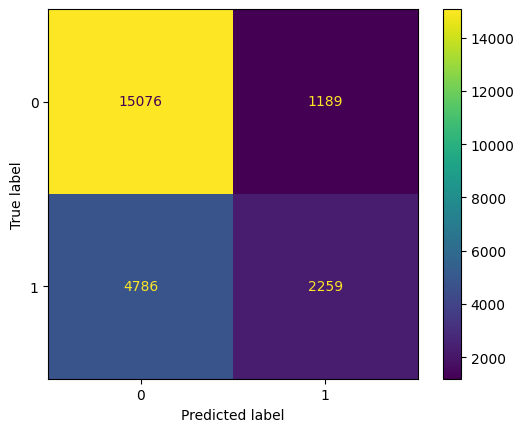

In [63]:
print('\n')
print('Confusion Matrix:')

ConfusionMatrixDisplay.from_predictions(Y_test, Y_pred)
plt.show()

### Random Forest

In [64]:
random_forest = RandomForestClassifier(n_estimators=100)

random_forest.fit(X_train, Y_train)

Y_pred = random_forest.predict(X_test)

Accuracy do modelo: 74.00%


Confusion Matrix:


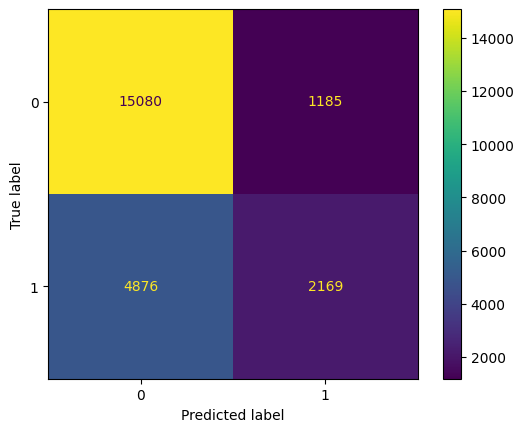

In [65]:
print("Accuracy do modelo: {:.2%}".format(accuracy_score(Y_pred,Y_test)))
print('\n')
print('Confusion Matrix:')

ConfusionMatrixDisplay.from_predictions(Y_test, Y_pred)
plt.show()

### XGBClassifier

In [66]:
  best_fit = xgb.XGBClassifier(eta = 0.1,
                        gamma = 0.1,
                        reg_lambda = 5,
                        alpha = 0.1,
                        max_depth = 7,
                        min_child_weight = 3,
                        max_delta_step=1,
                        objective = 'binary:logistic',
                        scale_pos_weight = 1,
                        seed = 12,
                        colsample_bytree=0.8,
                        subsample=0.6,                        
                        n_estimators = 200,
                        early_stoping=50)
                        #enable_categorical=True)

best_fit.fit(X_train, Y_train,
             eval_metric="auc")

[11:39:05] WARNING: ../src/learner.cc:767: 
Parameters: { "early_stoping" } are not used.



XGBClassifier(alpha=0.1, base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, early_stoping=50,
              early_stopping_rounds=None, enable_categorical=False, eta=0.1,
              eval_metric=None, feature_types=None, gamma=0.1, gpu_id=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None, max_delta_step=1,
              max_depth=7, max_leaves=None, min_child_weight=3, missing=nan,
              monotone_constraints=None, n_estimators=200, n_jobs=None, ...)

Accuracy do modelo: 74.51%


Confusion Matrix:


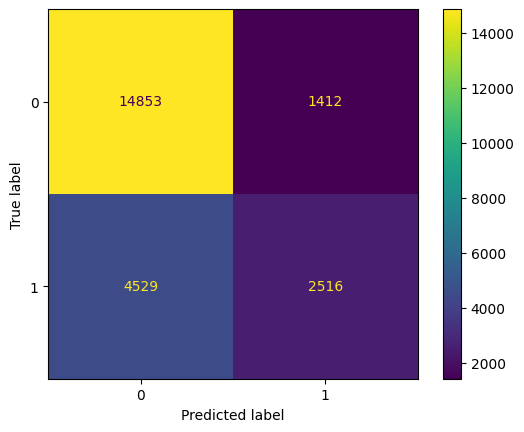

In [67]:
#reg.fit(X_train, Y_train)

ypred=best_fit.predict(X_test)

print("Accuracy do modelo: {:.2%}".format(accuracy_score(ypred,Y_test)))
print('\n')
print('Confusion Matrix:')

ConfusionMatrixDisplay.from_predictions(Y_test, ypred)
plt.show()

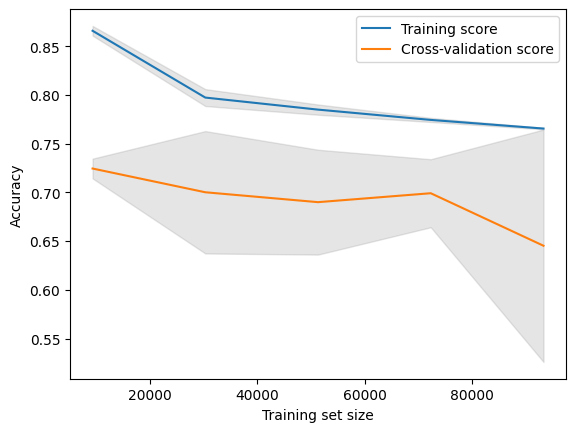

In [68]:
# use learning_curve() to get training and test scores
train_sizes, train_scores, test_scores = learning_curve(clf, X, Y, cv=5, scoring='accuracy')

# calculate the mean and standard deviation for the training scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)

# calculate the mean and standard deviation for the test scores
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# plot the learning curves
plt.plot(train_sizes, train_mean, label='Training score')
plt.plot(train_sizes, test_mean, label='Cross-validation score')

# add the standard deviation lines
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color='gray', alpha=0.2)
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color='gray', alpha=0.2)

# format the plot
plt.xlabel('Training set size')
plt.ylabel('Accuracy')
plt.legend(loc='best')
plt.show()

In [69]:
X.shape

(116546, 27)

In [70]:
unique, counts = np.unique(ypred, return_counts=True)

print('Quantidade prevista por label:')
print('\n')

print (np.asarray((unique, counts)).T)

Quantidade prevista por label:


[[    0 19382]
 [    1  3928]]


### CATBOOST

In [71]:
pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.6/76.6 MB 11.4 MB/s eta 0:00:00


Accuracy do modelo: 74.98%


Confusion Matrix:


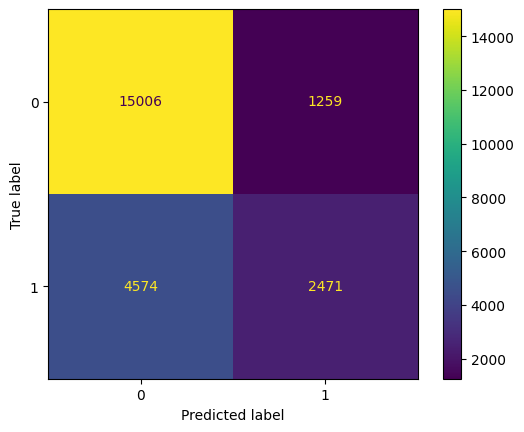

In [72]:
from catboost import CatBoostClassifier, Pool

cat = CatBoostClassifier()

cat.fit(X_train, Y_train, verbose=False)

cat_pred = cat.predict(X_test)

print("Accuracy do modelo: {:.2%}".format(accuracy_score(cat_pred,Y_test)))
print('\n')
print('Confusion Matrix:')

ConfusionMatrixDisplay.from_predictions(Y_test, cat_pred)
plt.show()

### Aplicação do Modelo

In [73]:
X_Pred = predict_df[['LOCA_ID', 'STCM_CDSETORCOMERCIAL', 'IPER_ID',
       'IMOV_IDSUBCATEGORIAPRINCIPAL', 'IDADE', 'IMOV_NNMORADOR',
       'QTDANORMALIDADEANTTOTAL', 'QTDANORMALIDADELEITURA_ANT', 'QTDECONOMIA',
       'QUANTIDADECONTAS', 'QUANTIDADERAS', 'POCO_ID', 'N_CORTES', 'CAPACIDADE_HD', 'MAX_CONSUMO', 
       'SOMATORIO_CONSUMO', 'r2', 'SLOPE', 'SLOPE_6', 'INTERCEPT', 'INTERCEPT_6', 'MEAN_ANT',
       'MEDIAN_ANT', 'SD_ANT', 'CONT_ZEROS','SOMATORIO_POR_MES','TEMPO_ATIVIDADE']]

predicao = best_fit.predict(X_Pred)

In [74]:
predicao = pd.DataFrame(data = predicao, columns = ['RESULT_MEAN'])

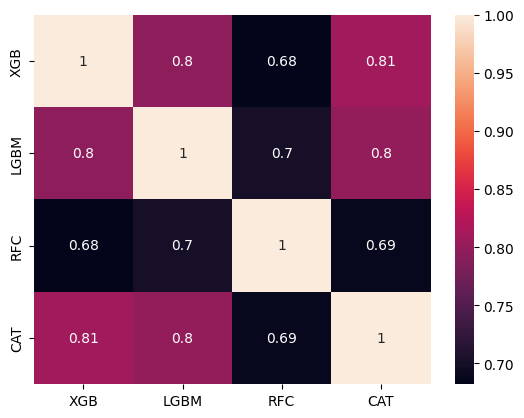

In [75]:
test_XGB = pd.Series(best_fit.predict(X_test), name="XGB")

test_LGBM = pd.Series(clf.predict(X_test), name="LGBM")

test_RFC = pd.Series(random_forest.predict(X_test), name="RFC")

test_CAT = pd.Series(cat.predict(X_test), name="CAT")

ensemble_results = pd.concat([test_XGB,test_LGBM,test_RFC, test_CAT],axis=1)

g= sns.heatmap(ensemble_results.corr(),annot=True)

In [76]:
votingC = VotingClassifier(estimators=[('xgb', best_fit), ('lgbm', clf), ('rfc',random_forest),('cat',cat)], voting='soft', n_jobs=4)

votingC = votingC.fit(X_train, Y_train)

In [77]:
ypred_vot=votingC.predict(X_test)

print("Accuracy do modelo: {:.2%}".format(accuracy_score(ypred_vot,Y_test)))
print('\n')
print('Confusion Matrix:')

''' plot_confusion_matrix(votingC, X_test, Y_test)

plt.show() '''

Accuracy do modelo: 74.75%


Confusion Matrix:


' plot_confusion_matrix(votingC, X_test, Y_test)\n\nplt.show() '

In [78]:
''' filename = 'modelo_combinado.sav'

pickle.dump(votingC, open(filename, 'wb')) '''

" filename = 'modelo_combinado.sav'\n\npickle.dump(votingC, open(filename, 'wb')) "

In [79]:
''' loaded_model = pickle.load(open(filename, 'rb')) '''

" loaded_model = pickle.load(open(filename, 'rb')) "

In [80]:
Base_Pred = predict_df.loc[:, ['IMOV_ID', 'LOCA_ID', 'STCM_CDSETORCOMERCIAL', 'IDADE','MEDIAN_ANT','MEAN_ANT', 'TEMPO_ATIVIDADE', 'SLOPE', 'QTDANORMALIDADELEITURA_ANT', 'SOMATORIO_CONSUMO']]

result_best = pd.Series(best_fit.predict(X_Pred), name="result_troca")

resultado = pd.concat([Base_Pred, result_best], axis = 1)

result_voting = pd.Series(votingC.predict(X_Pred), name="result_voting")

resultado_voting = pd.concat([Base_Pred, result_voting], axis = 1)

In [81]:
resultado['result_troca'].value_counts()

0    18695
1      219
Name: result_troca, dtype: int64

In [82]:
resultado_voting['result_voting'].value_counts()

0    18767
1      147
Name: result_voting, dtype: int64

In [83]:
prev = pd.concat([Base_Pred, predicao], axis = 1)

prev.tail()

,IMOV_ID,LOCA_ID,STCM_CDSETORCOMERCIAL,IDADE,MEDIAN_ANT,MEAN_ANT,TEMPO_ATIVIDADE,SLOPE,QTDANORMALIDADELEITURA_ANT,SOMATORIO_CONSUMO,RESULT_MEAN
18909,109635876,41,701,2,5.0,5.166667,545,-0.034965,0,120.0,0
18910,109625633,41,851,2,17.0,17.750000,546,0.241259,0,328.0,0
18911,109671279,41,925,2,8.0,9.916667,510,1.395105,0,180.0,0
18912,109704720,41,801,2,1.5,4.666667,459,-1.055944,0,108.0,0
18913,109832990,41,891,1,10.0,8.833333,260,-1.202797,1,106.0,0


In [84]:
prev['PROBABILIDADE'] = best_fit.predict_proba(X_Pred)[:,1]

In [85]:
prev[prev['RESULT_MEAN'] == 1].sort_values(by='PROBABILIDADE', ascending = False).head(10)

,IMOV_ID,LOCA_ID,STCM_CDSETORCOMERCIAL,IDADE,MEDIAN_ANT,MEAN_ANT,TEMPO_ATIVIDADE,SLOPE,QTDANORMALIDADELEITURA_ANT,SOMATORIO_CONSUMO,RESULT_MEAN,PROBABILIDADE
5366,77722590,41,841,5,103.5,97.583333,214,-25.108392,0,1170.0,1,0.946771
916,109670086,41,986,2,498.5,457.916667,773,-32.094406,0,6202.0,1,0.900405
4794,6977308,41,986,5,119.0,95.666667,270,-11.664336,0,1148.0,1,0.893301
13054,6170757,41,581,13,0.0,18.083333,4237,-6.989510,3,6332.0,1,0.862359
13951,6201873,41,551,1,21.5,16.250000,249,-3.590909,0,195.0,1,0.861106
1532,6673015,41,861,5,72.5,81.000000,159,-15.055944,0,824.0,1,0.841765
4760,6996728,41,871,1,0.0,12.750000,52,-5.800699,0,141.0,1,0.832391
4385,109266978,41,270,4,62.0,43.250000,976,6.653846,0,1981.0,1,0.831731
18606,109266862,41,270,4,0.0,1.916667,976,0.884615,0,660.0,1,0.822236
2569,106656104,41,721,8,0.0,0.000000,2818,0.000000,19,2979.0,1,0.819278


In [86]:
# df_locs = pd.read_excel(r'/content/drive/MyDrive/Compesa_CHD/localidades_Gregs.xlsx', sheet_name = 'locas')

In [87]:
 # df_locs = prev.merge(df_locs)

In [88]:
ano = date.today().year
mes = date.today().month
dia = date.today().day
print('Digite o nome da unidade')
unidade = input()
amd = f"{str(ano)}{str(mes)}{str(dia)}_predicao_{unidade}.xlsx"

Digite o nome da unidade
bhghcf


In [89]:
#df_locs.to_excel(amd, index=False)

In [90]:
prev[(prev['TEMPO_ATIVIDADE']>= 1440) & (prev['TEMPO_ATIVIDADE']< 2880) & (prev['RESULT_MEAN'] == 1)].shape

(49, 12)

In [91]:
prev[prev['RESULT_MEAN'] == 1].shape

(219, 12)

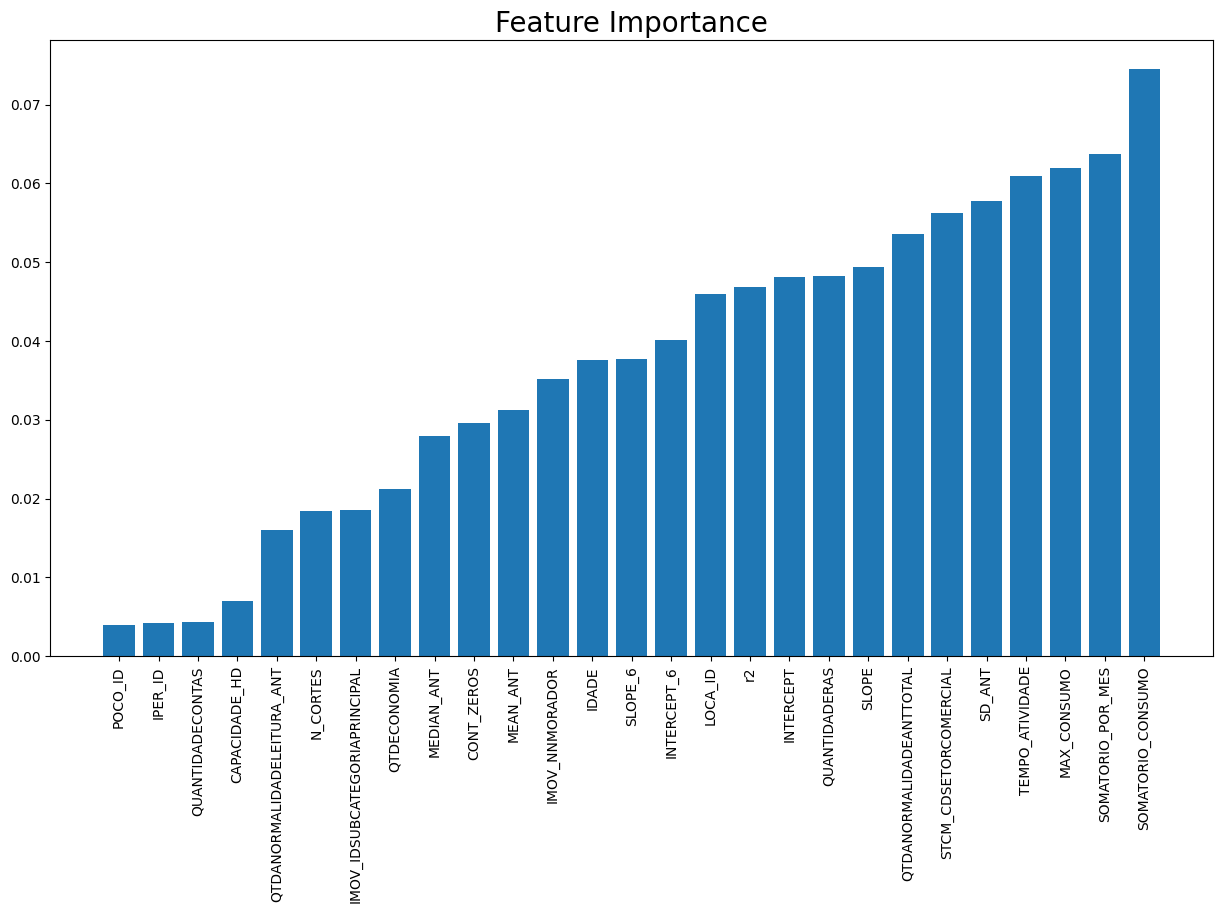

In [92]:
dici = dict(zip(X_Pred.columns, random_forest.feature_importances_))

dici = dict(sorted(dici.items(), key=lambda item: item[1]))

features = list(dici.keys())

feat_importance = list(dici.values())

fig, axes = plt.subplots(figsize = (15, 8))

plt.bar(range(len(features)), feat_importance, tick_label = features)

plt.title('Feature Importance', fontsize = 20)

plt.xticks(rotation = 90)

plt.show()

In [93]:
aval = prev[(prev['IDADE']>= 5) & (prev['RESULT_MEAN'] == 1)]

In [94]:
aval.groupby(['LOCA_ID', 'STCM_CDSETORCOMERCIAL'])['IMOV_ID'].count().sort_values(ascending=False).head().reset_index()

,LOCA_ID,STCM_CDSETORCOMERCIAL,IMOV_ID
0,41,953,27
1,41,861,7
2,41,986,7
3,131,160,5
4,41,581,5


In [95]:
aval[(aval['LOCA_ID'] == 342) & (aval['STCM_CDSETORCOMERCIAL'] == 522)]['IMOV_ID']

Series([], Name: IMOV_ID, dtype: int64)

In [96]:
prev[prev['RESULT_MEAN'] == 1].sort_values(by='PROBABILIDADE', ascending = False).head(10)

,IMOV_ID,LOCA_ID,STCM_CDSETORCOMERCIAL,IDADE,MEDIAN_ANT,MEAN_ANT,TEMPO_ATIVIDADE,SLOPE,QTDANORMALIDADELEITURA_ANT,SOMATORIO_CONSUMO,RESULT_MEAN,PROBABILIDADE
5366,77722590,41,841,5,103.5,97.583333,214,-25.108392,0,1170.0,1,0.946771
916,109670086,41,986,2,498.5,457.916667,773,-32.094406,0,6202.0,1,0.900405
4794,6977308,41,986,5,119.0,95.666667,270,-11.664336,0,1148.0,1,0.893301
13054,6170757,41,581,13,0.0,18.083333,4237,-6.989510,3,6332.0,1,0.862359
13951,6201873,41,551,1,21.5,16.250000,249,-3.590909,0,195.0,1,0.861106
1532,6673015,41,861,5,72.5,81.000000,159,-15.055944,0,824.0,1,0.841765
4760,6996728,41,871,1,0.0,12.750000,52,-5.800699,0,141.0,1,0.832391
4385,109266978,41,270,4,62.0,43.250000,976,6.653846,0,1981.0,1,0.831731
18606,109266862,41,270,4,0.0,1.916667,976,0.884615,0,660.0,1,0.822236
2569,106656104,41,721,8,0.0,0.000000,2818,0.000000,19,2979.0,1,0.819278


In [97]:
prev[prev['RESULT_MEAN'] == 1].groupby('IDADE')['IMOV_ID'].count().sort_values(ascending = False)

IDADE
1     41
16    31
11    25
13    20
3     15
10    15
12    15
4     11
5     11
2     10
7      8
8      7
6      3
9      3
14     3
15     1
Name: IMOV_ID, dtype: int64

In [98]:
prev[(prev['LOCA_ID'] == 60) & (prev['PROBABILIDADE'] > 0.5)]

,IMOV_ID,LOCA_ID,STCM_CDSETORCOMERCIAL,IDADE,MEDIAN_ANT,MEAN_ANT,TEMPO_ATIVIDADE,SLOPE,QTDANORMALIDADELEITURA_ANT,SOMATORIO_CONSUMO,RESULT_MEAN,PROBABILIDADE
